In [1]:
import math
import random
import yaml
import argparse
from dotmap import DotMap

import numpy as np
import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.optim import Adam
from torch.nn.functional import cosine_similarity

import matplotlib.pyplot as plt
import wandb

In [2]:
import sys
sys.path.append("./src")  # make sure Python can find src/
# from model_softmax import GPTSoftmax
from data import MovingWindowSum

In [3]:
"""
Andrej Karpathy's minGPT implementation (https://github.com/karpathy/minGPT/blob/master/mingpt/model.py)

Full definition of a GPT Language Model, all of it in this single file.

References:
1) the official GPT-2 TensorFlow implementation released by OpenAI:
https://github.com/openai/gpt-2/blob/master/src/model.py
2) huggingface/transformers PyTorch implementation:
https://github.com/huggingface/transformers/blob/main/src/transformers/models/gpt2/modeling_gpt2.py
"""

import math

import torch
import torch.nn as nn
from torch.nn import functional as F

# from mingpt.utils import CfgNode as CN

# -----------------------------------------------------------------------------


class NewGELU(nn.Module):
    """
    Implementation of the GELU activation function currently in Google BERT repo (identical to OpenAI GPT).
    Reference: Gaussian Error Linear Units (GELU) paper: https://arxiv.org/abs/1606.08415
    """

    def forward(self, x):
        return (
            0.5
            * x
            * (
                1.0
                + torch.tanh(
                    math.sqrt(2.0 / math.pi) * (x + 0.044715 * torch.pow(x, 3.0))
                )
            )
        )


class CausalSelfAttention(nn.Module):
    """
    A vanilla multi-head masked self-attention layer with a projection at the end.
    It is possible to use torch.nn.MultiheadAttention here but I am including an
    explicit implementation here to show that there is nothing too scary here.
    """

    def __init__(self, config, return_att=False):
        super().__init__()
        assert config.n_embd % config.n_head == 0

        # key, query, value projections for all heads
        self.k = nn.Linear(config.n_embd, config.n_embd)
        self.q = nn.Linear(config.n_embd, config.n_embd)
        self.v = nn.Linear(config.n_embd, config.n_embd)
        
        # output projection
        self.c_proj = nn.Linear(config.n_embd, config.n_embd)

        # causal mask to ensure that attention is only applied to the left in the input sequence
        self.register_buffer(
            "bias",
            torch.tril(torch.ones(config.block_size, config.block_size)).view(
                1, 1, config.block_size, config.block_size
            ),
        )
        
        self.n_head = config.n_head
        self.n_embd = config.n_embd
        self.return_att = return_att

    def forward(self, x):
        B, T, C = (
            x.size()
        )  # batch size, sequence length, embedding dimensionality (n_embd)

        # calculate query, key, values for all heads
        q = self.q(x)
        k = self.k(x)
        v = self.v(x)

        k = k.view(B, T, self.n_head, C // self.n_head).transpose(
            1, 2
        )  # (B, nh, T, hs)
        q = q.view(B, T, self.n_head, C // self.n_head).transpose(
            1, 2
        )  # (B, nh, T, hs)
        v = v.view(B, T, self.n_head, C // self.n_head).transpose(
            1, 2
        )  # (B, nh, T, hs)

        # causal self-attention; Self-attend: (B, nh, T, hs) x (B, nh, hs, T) -> (B, nh, T, T)
        att = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1)))
        att = att.masked_fill(self.bias[:, :, :T, :T] == 0, float('-inf'))
        att = F.softmax(att, dim=-1)
        
        att_copy = att.clone().detach()

        y = att @ v  # (B, nh, T, T) x (B, nh, T, hs) -> (B, nh, T, hs)
        y = (
            y.transpose(1, 2).contiguous().view(B, T, C)
        )  # re-assemble all head outputs side by side

        # output projection
        y = self.c_proj(y)

        if self.return_att:
            return y, att_copy

        return y


class Block(nn.Module):
    """an unassuming Transformer block"""

    def __init__(self, config, return_att=False):
        super().__init__()
        self.ln_1 = nn.LayerNorm(config.n_embd)
        self.attn = CausalSelfAttention(config, return_att=return_att)
        self.ln_2 = nn.LayerNorm(config.n_embd)
        self.mlp = nn.ModuleDict(
            dict(
                c_fc=nn.Linear(config.n_embd, 4 * config.n_embd),
                c_proj=nn.Linear(4 * config.n_embd, config.n_embd),
                act=NewGELU(),
                # dropout=nn.Dropout(config.resid_pdrop),
            )
        )
        
        m = self.mlp
        self.mlpf = lambda x: m.c_proj(m.act(m.c_fc(x)))  # MLP forward
        self.return_att = return_att

    def forward(self, x):
        if self.return_att:
            x_prev, att = self.attn(self.ln_1(x))
            x = x + x_prev
            
            x = x + self.mlpf(self.ln_2(x))
            
            return x, att

        else:
            x = x + self.attn(self.ln_1(x))
            x = x + self.mlpf(self.ln_2(x))
            return x


class GPTSoftmax(nn.Module):
    """GPT Language Model"""

    def __init__(self, config, return_att=False):
        super().__init__()
        assert config.vocab_size is not None
        assert config.block_size is not None
        self.block_size = config.block_size
        self.return_att = return_att

        self.transformer = nn.ModuleDict(
            dict(
                wte=nn.Embedding(config.vocab_size, config.n_embd),
                wpe=nn.Embedding(config.block_size, config.n_embd),
                h=nn.ModuleList(
                    [
                        Block(config, return_att=self.return_att)
                        for _ in range(config.n_layer)
                    ]
                ),
                ln_f=nn.LayerNorm(config.n_embd),
            )
        )
        self.lm_head = nn.Linear(config.n_embd, config.vocab_size, bias=False)

        # init all weights, and apply a special scaled init to the residual projections, per GPT-2 paper
        self.apply(self._init_weights)
        for pn, p in self.named_parameters():
            if pn.endswith("c_proj.weight"):
                torch.nn.init.normal_(
                    p, mean=0.0, std=0.02 / math.sqrt(2 * config.n_layer)
                )

        # report number of parameters (note we don't count the decoder parameters in lm_head)
        n_params = sum(p.numel() for p in self.transformer.parameters())
        # print("number of parameters: %.2fM" % (n_params / 1e6,))

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
        elif isinstance(module, nn.LayerNorm):
            torch.nn.init.zeros_(module.bias)
            torch.nn.init.ones_(module.weight)


    # Only used for weight decay experiments -------------------------------------------
    def configure_optimizers(self, train_config):
        """
        This long function is unfortunately doing something very simple and is being very defensive:
        We are separating out all parameters of the model into two buckets: those that will experience
        weight decay for regularization and those that won't (biases, and layernorm/embedding weights).
        We are then returning the PyTorch optimizer object.
        """

        # separate out all parameters to those that will and won't experience regularizing weight decay
        decay = set()
        no_decay = set()
        whitelist_weight_modules = (torch.nn.Linear, )
        blacklist_weight_modules = (torch.nn.LayerNorm, torch.nn.Embedding)
        for mn, m in self.named_modules():
            for pn, p in m.named_parameters():
                fpn = '%s.%s' % (mn, pn) if mn else pn # full param name
                # random note: because named_modules and named_parameters are recursive
                # we will see the same tensors p many many times. but doing it this way
                # allows us to know which parent module any tensor p belongs to...
                if pn.endswith('bias'):
                    # all biases will not be decayed
                    no_decay.add(fpn)
                elif pn.endswith('weight') and isinstance(m, whitelist_weight_modules):
                    # weights of whitelist modules will be weight decayed
                    decay.add(fpn)
                elif pn.endswith('weight') and isinstance(m, blacklist_weight_modules):
                    # weights of blacklist modules will NOT be weight decayed
                    no_decay.add(fpn)

        # validate that we considered every parameter
        param_dict = {pn: p for pn, p in self.named_parameters()}
        inter_params = decay & no_decay
        union_params = decay | no_decay
        assert len(inter_params) == 0, "parameters %s made it into both decay/no_decay sets!" % (str(inter_params), )
        assert len(param_dict.keys() - union_params) == 0, "parameters %s were not separated into either decay/no_decay set!" \
                                                    % (str(param_dict.keys() - union_params), )

        # create the pytorch optimizer object
        optim_groups = [
            {"params": [param_dict[pn] for pn in sorted(list(decay))], "weight_decay": train_config.wd},
            {"params": [param_dict[pn] for pn in sorted(list(no_decay))], "weight_decay": 0.0},
        ]
        optimizer = torch.optim.AdamW(optim_groups, lr=train_config.lr)
        return optimizer
    # -------------------------------------------


    def forward(self, idx, prompt_len, targets=None, mask_idx =None):
        device = idx.device
        b, t = idx.size()
        assert (
            t <= self.block_size
        ), f"Cannot forward sequence of length {t}, block size is only {self.block_size}"
        pos = torch.arange(0, t, dtype=torch.long, device=device).unsqueeze(
            0
        )  # shape (1, t)

        # forward the GPT model itself
        tok_emb = self.transformer.wte(idx)  # token embeddings of shape (b, t, n_embd)
        pos_emb = self.transformer.wpe(pos)  # position embeddings of shape (1, t, n_embd)
        x = tok_emb + pos_emb
        
        for block in self.transformer.h:
            if self.return_att:
                x, attn_map = block(x)
            else:
                x = block(x)

        
        x = self.transformer.ln_f(x)
        
        # Track residual state before LM head for representation collapse
        pre_lm_h = x.clone().detach()
        
        # Final logits
        logits = self.lm_head(x)

        # if we are given some desired targets also calculate the loss
        loss = None
        if targets is not None:
            # Masking input tokens
            targets_masked = targets.clone()
            targets_masked[:, :prompt_len-1] = -1
            if mask_idx:
                targets_masked[:, prompt_len+mask_idx:] = -1
            loss = F.cross_entropy(
                logits.reshape(-1, logits.size(-1)),
                targets_masked.reshape(-1),
                # targets.reshape(-1),
                ignore_index=-1,
            )

        if self.return_att:
            return attn_map, pre_lm_h, logits, loss
        
        return pre_lm_h, logits, loss
    
    @torch.no_grad()
    def generate(
        self, idx, max_new_tokens, prompt_len, temperature=1.0, do_sample=False, top_k=None, mask_idx= None
    ):
        """
        Take a conditioning sequence of indices idx (LongTensor of shape (b,t)) and complete
        the sequence max_new_tokens times, feeding the predictions back into the model each time.
        Most likely you'll want to make sure to be in model.eval() mode of operation for this.
        """
        
        for _ in range(max_new_tokens):
            # if the sequence context is growing too long we must crop it at block_size
            idx_cond = (
                idx if idx.size(1) <= self.block_size else idx[:, -self.block_size :]
            )
            # forward the model to get the logits for the index in the sequence
            _, _, logits, _ = self(idx_cond, prompt_len=prompt_len, mask_idx= mask_idx)
            # pluck the logits at the final step and scale by desired temperature
            logits = logits[:, -1, :] / temperature
            # optionally crop the logits to only the top k options
            if top_k is not None:
                v, _ = torch.topk(logits, top_k)
                logits[logits < v[:, [-1]]] = -float("Inf")
            # apply softmax to convert logits to (normalized) probabilities
            probs = F.softmax(logits, dim=-1)
            # either sample from the distribution or take the most likely element
            if do_sample:
                idx_next = torch.multinomial(probs, num_samples=1)
            else:
                _, idx_next = torch.topk(probs, k=1, dim=-1)
            # append sampled index to the running sequence and continue
            idx = torch.cat((idx, idx_next), dim=1)

        return idx


In [4]:
# Data

class MovingWindowSum:
    def __init__(self, min_num=1, max_num=16, k=2, p=17, sep=17, device="cuda"):
        self.min_num = min_num
        self.max_num = max_num
        self.k = k
        self.p = p
        self.sep = sep
        self.device = device
        assert self.p > self.max_num

    @torch.no_grad()
    def sample(
        self,
        num_samples,
        num_tokens,
    ):
        random_ints = torch.randint(
            low=self.min_num, high=self.max_num + 1, size=(num_samples, num_tokens)
        ).to(self.device)

        random_ints_np = random_ints.detach().cpu().numpy()
        convolution = torch.stack(
            [
                torch.from_numpy(
                    np.convolve(
                        random_ints_np[i],
                        np.ones(self.k),
                        mode="valid",
                    )
                )
                for i in range(random_ints.shape[0])
            ]
        )

        moving_sum = random_ints.clone().detach()
        moving_sum[:, self.k - 1 :] = convolution

        # for i in range(num_samples):
        #     for j in range(0, self.k - 1):
        #         if moving_sum[i, j] != random_ints[i, j]:
        #             print(f"ERROR! {i} {j}")
        #     for j in range(self.k - 1, num_tokens):
        #         if moving_sum[i, j] != torch.sum(random_ints[i, j-self.k+1:j+1]):
        #             print(f"ERROR! {i} {j}")

        # exit()
        samples = (
            torch.cat(
                [
                    random_ints,
                    self.sep * torch.ones(size=(num_samples, 1)).to(self.device),
                    torch.remainder(input=moving_sum, other=self.p),
                ],
                axis=-1,
            )
            .to(int)
            .detach()
        )

        return samples

In [10]:
# Train
def train_step(
    model,
    optim,
    data_sampler,
    step,
    config,
    mask_idx = None
):
    n_train, n_test, num_tokens = (
        config.data.n_train,
        config.data.n_test,
        config.data.num_tokens,
    )

    data = data_sampler.sample(
        num_samples=n_train + n_test,
        num_tokens=num_tokens,
    )

    train_data = data[:n_train, :]
    test_data = data[n_train:, :]

    prompt_len = num_tokens + 1
    gen_len = num_tokens
    acc_start = num_tokens + 1

    model.train()
    optim.zero_grad(set_to_none=True)

    targets = train_data[:, 1:].clone().long()
    # targets[:, :prompt_len-1] = -1
    # if mask_idx: ## Mask idx will correspond to the y_maskidx and onwards being masked (0 indexed)
    #     targets[:, (prompt_len + mask_idx):] = -1
        
    _, _, _, loss = model(
        train_data[:, :-1], targets=targets, prompt_len =prompt_len, mask_idx=mask_idx,
    )
    loss.backward()

    if config.train.grad_clip > 0:
        torch.nn.utils.clip_grad_norm_(model.parameters(), config.train.grad_clip)

    optim.step()

    model.eval()
    with torch.no_grad():
        # Log train loss, train / test acc, repetition frequency
        attn_map, pre_lm_h, _, train_loss = model(train_data[:, :-1], targets=train_data[:, 1:], prompt_len =prompt_len, mask_idx= mask_idx)

        train_pred = model.generate(
            idx=train_data[:, :prompt_len],
            max_new_tokens=gen_len,
            prompt_len =prompt_len,
            mask_idx= mask_idx,
        )
        test_pred = model.generate(
            idx=test_data[:, :prompt_len],
            max_new_tokens=gen_len,
            prompt_len =prompt_len,
            mask_idx= mask_idx,
        )

        train_acc = torch.mean(
            (train_pred[:, acc_start:] == train_data[:, acc_start:]).to(float)
        ).item()
        test_acc = torch.mean(
            (test_pred[:, acc_start:] == test_data[:, acc_start:]).to(float)
        ).item()

        data_repeat_frac = torch.mean((test_data[:, acc_start:-1] == test_data[:, acc_start+1:]).to(float))
        model_repeat_frac = torch.mean((test_pred[:, acc_start:-1] == test_pred[:, acc_start+1:]).to(float))

        # Log attention progress measure
        attn_map_output_seq = attn_map[:, :, acc_start-1:]
        att_mask = torch.zeros_like(attn_map_output_seq).to(device)

        att_mask[:, :, 0, 0] = 1
        for i in range(num_tokens - 1):
            att_mask[:, :, i + 1, i : i + 2] = 1

        att_prog_measure = torch.mean(
            torch.sum(torch.abs(attn_map_output_seq) * att_mask, dim=(-3, -2, -1)) /
            torch.sum(torch.abs(attn_map_output_seq), dim=(-3, -2, -1)),
            dim=0
        )

        # Log pair-wise cosine similarity between hidden states
        embed_start = acc_start - 1
        embed_len = gen_len

        logit_cs = torch.zeros((embed_len, embed_len))

        for i_1 in range(embed_start, embed_start + embed_len):
            for i_2 in range(embed_start, i_1):
                logit_cs[i_1 - embed_start, i_2 - embed_start] = torch.mean(
                    (
                        cosine_similarity(
                            pre_lm_h[:, i_1, :], pre_lm_h[:, i_2, :], dim=-1
                        )
                    ), dim=0
                )

        # Log plots for cosine similarity, attention map
        logit_fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(30, 15))

        im1 = ax[0].imshow(logit_cs)
        ax[0].set_title("avg pre_lm_h cosine sim")
        cb1 = logit_fig.colorbar(im1, location="right", shrink=0.99, pad=0.02, ax=ax[0])

        avg_attn_map = torch.mean(attn_map, dim=0).squeeze().detach().cpu().numpy()

        im2 = ax[1].imshow(avg_attn_map)
        ax[1].set_title("att map")
        cb4 = logit_fig.colorbar(im2, location="right", shrink=0.99, pad=0.02, ax=ax[1])
        ax[1].set_xticks(range(avg_attn_map.shape[-1]))
        ax[1].set_yticks(range(avg_attn_map.shape[-2]))

        for i1 in range(embed_len):
            for i2 in range(embed_len):
                text1 = ax[0].text(
                    i2,
                    i1,
                    round(logit_cs[i1, i2].item(), 2),
                    ha="center",
                    va="center",
                    color="w",
                )


        print(
            f"Step {step} -- Train loss: {train_loss}, Train Acc: {train_acc} Test Acc: {test_acc}"
        )
        # print(f"input: {test_data[0]} \n predicted:{test_pred[0]}")

        if config.train.wandb:

            log_data = {
                "train_loss": train_loss,
                "train_acc": train_acc,
                "test_acc": test_acc,
                "data_repeat_frac": data_repeat_frac,
                "model_repeat_frac": model_repeat_frac,
                "att_prog_measure": att_prog_measure,
                "pre_lm_h_cosine_sim": logit_fig,
                "mean_cosine_sim": torch.sum(logit_cs[:, 1:]) / (0.5 * (gen_len-1) * (gen_len-2))
            }

            for output_pos in range(gen_len):
                log_data.update(
                    {
                        f"idx{output_pos}_check": torch.mean(
                            (train_pred[:, acc_start + output_pos] == train_data[:, acc_start + output_pos]).to(float)
                        ).item()
                    }
                )

                if output_pos < gen_len-1:
                    log_data.update(
                        {
                            f"mean_cosine_sim_{output_pos}": torch.sum(logit_cs[:, output_pos]) / (gen_len-1-output_pos)
                        }
                    )

            wandb.log(log_data)

        plt.close()
        del (
            logit_fig,
            ax,
            logit_cs,
        )

        if config.train.save_ckpt:
            if (step == 0) or ((step + 1) % config.train.ckpt_freq == 0):
                model.train()
                torch.save(
                    {
                        "epoch": step,
                        "model": model.state_dict(),
                        "optim": optim.state_dict(),
                        "train_loss": train_loss,
                        "test_acc": test_acc,
                    },
                    "./mws_k2_l1_h1_a16_n16.tar",
                )
                print(f"saved state at epoch {step} to {f'./mws_k2_l1_h1_a16_n16.tar'}")

                if config.train.wandb:
                    model_wandb = wandb.Artifact(
                        f"model_step{step}", type="model"
                    )
                    model_wandb.add_file(f"./mws_k2_l1_h1_a16_n16.tar")
                    wandb.log_artifact(model_wandb)
                    print("model uploaded to wandb")

In [11]:
# Config

device = "cuda" if torch.cuda.is_available() else "cpu"

config = {
'model':
  {
    'n_layer': 1,
    'n_head': 1,
    'n_embd': 256,
    'linear': True,
  },

'data':
  {
    'name': 'window',
    'min_num': 1,
    'max_num': 16,
    'k': 2,
    'p': 17,
    'sep': 17,
    'cot': False,
    'num_tokens': 16,
    'n_train': 256,
    'n_test': 64,
    'fixed_len': True,
  },

'train':
  {
    'lr': 0.0005,
    'grad_clip': -1,
    'num_steps': 2000,
    'norm_type': "none_rank",
    'wandb': True,
    'save_ckpt': False,
    'ckpt_freq': 20,
  }
}

In [12]:
config = DotMap(config)
config.train.num_steps = 10000

In [23]:
config.model.vocab_size = max(config.data.p, config.data.max_num) + 1
config.model.block_size = 2 * config.data.num_tokens + 1

data_sampler = MovingWindowSum(
    min_num=config.data.min_num,
    max_num=config.data.max_num,
    k=config.data.k,
    p=config.data.p,
)

model = GPTSoftmax(config.model, return_att=True).to(device)
optim = Adam(model.parameters(), lr=config.train.lr)

if config.train.wandb:
    wandb_run_name = 'mws_softmax_attention_loss_noinput_lr0.0005_10kstep'
    wandb.login(key="")
    wandb.init(project="loss_plateau_tf", name=wandb_run_name, config=config)
    wandb.watch(model)

for step in range(config.train.num_steps):
    train_step(
        model=model,
        optim=optim,
        data_sampler=data_sampler,
        step=step,
        config=config,
    )

if config.train.wandb:
    wandb.finish()

AttributeError: 'dict' object has no attribute 'data'

### Testing how many tokens will break it down

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Step 0 -- Train loss: 2.8111727237701416, Train Acc: 0.063720703125 Test Acc: 0.0693359375
Step 1 -- Train loss: 2.804389476776123, Train Acc: 0.065673828125 Test Acc: 0.056640625
Step 2 -- Train loss: 2.7768750190734863, Train Acc: 0.066650390625 Test Acc: 0.044921875
Step 3 -- Train loss: 2.734684944152832, Train Acc: 0.06396484375 Test Acc: 0.068359375
Step 4 -- Train loss: 2.6788430213928223, Train Acc: 0.071044921875 Test Acc: 0.0654296875
Step 5 -- Train loss: 2.413708209991455, Train Acc: 0.095458984375 Test Acc: 0.095703125
Step 6 -- Train loss: 2.1097044944763184, Train Acc: 0.1142578125 Test Acc: 0.1220703125
Step 7 -- Train loss: 1.9844377040863037, Train Acc: 0.11181640625 Test Acc: 0.107421875
Step 8 -- Train loss: 1.7474783658981323, Train Acc: 0.115234375 Test Acc: 0.126953125
Step 9 -- Train loss: 1.6687363386154175, Train Acc: 0.109619140625 Test Acc: 0.1171875
Step 10 -- Train loss: 1.652341604232788, Train Acc: 0.113037109375 Test Acc: 0.115234375
Step 11 -- Train lo

KeyboardInterrupt: 

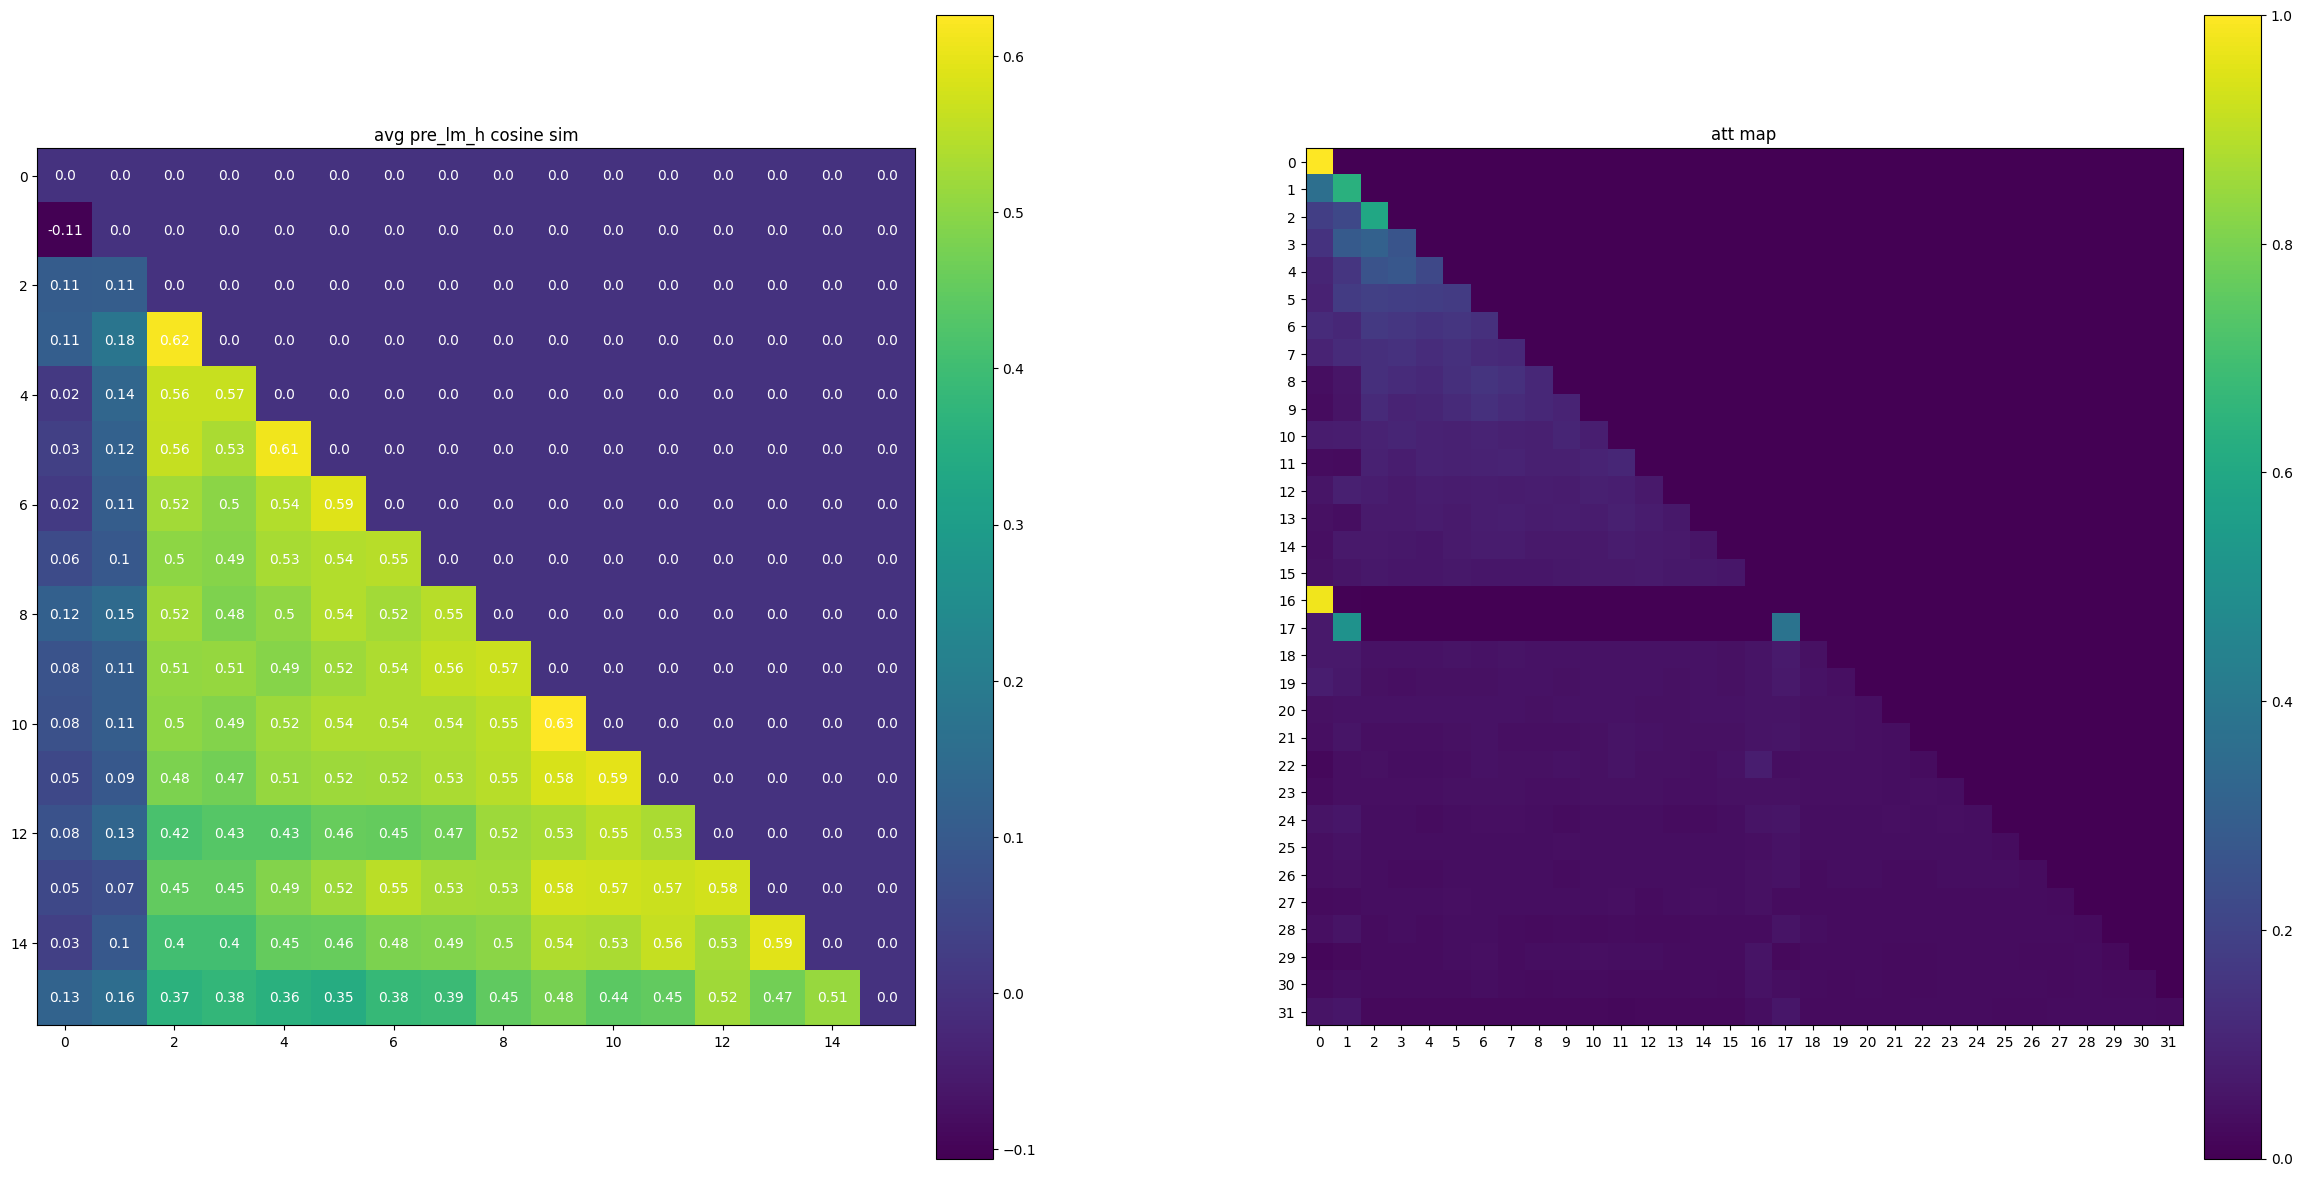

In [13]:
i=1
config.model.vocab_size = max(config.data.p, config.data.max_num) + 1
config.model.block_size = 2 * config.data.num_tokens + 1
config.train.num_steps = 1000

data_sampler = MovingWindowSum(
    min_num=config.data.min_num,
    max_num=config.data.max_num,
    k=config.data.k,
    p=config.data.p,
)

model = GPTSoftmax(config.model, return_att=True).to(device)
optim = Adam(model.parameters(), lr=config.train.lr)

if config.train.wandb:
    wandb_run_name = f'mws_softmax_attention_loss_noinput_first{i+1}thtoken'
    wandb.login(key="")
    wandb.init(project="loss_plateau_tf", name=wandb_run_name, config=config)
    wandb.watch(model)

for step in range(config.train.num_steps):
    train_step(
        model=model,
        optim=optim,
        data_sampler=data_sampler,
        step=step,
        config=config,
        mask_idx=i
    )

if config.train.wandb:
    wandb.finish()

In [ ]:


config.model.vocab_size = max(config.data.p, config.data.max_num) + 1
config.model.block_size = 2 * config.data.num_tokens + 1
config.train.num_steps = 10

data_sampler = MovingWindowSum(
    min_num=config.data.min_num,
    max_num=config.data.max_num,
    k=config.data.k,
    p=config.data.p,
)

for i in range(1, 16):
    # Instantiate model and optimizer
    model = GPTSoftmax(config.model, return_att=True).to(device)
    optim = Adam(model.parameters(), lr=config.train.lr)

    if config.train.wandb:
        wandb_run_name = f'mws_softmax_attention_loss_noinput_first{i+1}thtoken'
        wandb.login(key="")
        wandb.init(project="loss_plateau_tf", name=wandb_run_name, config=config)
        wandb.watch(model)

    try:
        for step in range(config.train.num_steps):
            train_step(
                model=model,
                optim=optim,
                data_sampler=data_sampler,
                step=step,
                config=config,
                mask_idx=i
            )
    finally:
        # Clean up after each model training
        del model
        del optim
        torch.cuda.empty_cache()  # Reclaim GPU memory

        if config.train.wandb:
            wandb.finish()